In [1]:
# workaround for multiple OpenMP on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
from pathlib import PurePath

import IPython.display as display
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

import numpy as np
import PIL.Image
import time
import functools

In [15]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)

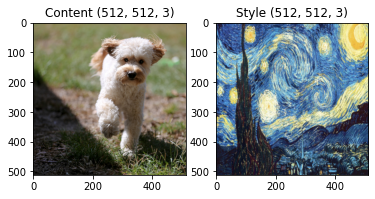

In [16]:
from skimage.transform import resize

content_path = 'images/dog.jpg'
style_path = 'images/starry_style.png'

content_image = load_img(content_path)
style_image = load_img(style_path)
style_image = resize(style_image,content_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

In [121]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder
        
        
        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images
        
        # DO NOT load models four and five becasue they are not great auto encoders
        # and therefore will casue weired artifacts when used for style trasnfer 
#         ModelBlock5 = tf.keras.models.load_model(str(PurePath(files_path, 'Block5_Model')), compile = False)
#         self.E5 = ModelBlock5.layers[0]
#         self.D5 = ModelBlock5.layers[1]
#         self.O5 = ModelBlock5.layers[2]

#         ModelBlock4 = tf.keras.models.load_model(str(PurePath(files_path, 'Block4_Model')), compile = False)
#         self.E4 = ModelBlock4.layers[0]
#         self.D4 = ModelBlock4.layers[1]
#         self.O4 = ModelBlock4.layers[2]
        
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0]
        self.D3 = ModelBlock3.layers[1]
        self.O3 = ModelBlock3.layers[2]
        
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0]
        self.D2 = ModelBlock2.layers[1]
        self.O2 = ModelBlock2.layers[2]
        
        # no special decoder for this one becasue VGG first layer has
        # no downsampling 
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0]
        self.O1 = ModelBlock1.layers[1]
        

    def call(self, image, alphas=None, training  = False):
        # Input should be dictionary with 'style' and 'content' keys
        # {'style':style_image, 'content':content_image}
        # value in each should be a 4D Tensor,: (batch, i,j, channel)
        
        style_image = image['style']
        content_image = image['content']
        
        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So eack key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)
        
        x = content_image
        
        if alphas==None:
            alphas = {'layer3':0.6, 
                      'layer2':0.6, 
                      'layer1':0.6}
        
        # ------Layer 3----------
        # apply whiten/color on layer 3 from the original image
        # get activations
        a_c = self.E3(tf.constant(x))
        a_s = self.E3(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = self.wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer3'])
        # decode the new style
        x = self.O3(self.D3(x))
        x = self.enhance_contrast(x)
        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended3 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (blended3, reconst3)
        
        # ------Layer 2----------
        # apply whiten/color on layer 2 from the already blended image
        # get activations
        a_c = self.E2(tf.constant(x))
        a_s = self.E2(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = self.wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer2'])
        # decode the new style
        x = self.O2(self.D2(x))
        x = self.enhance_contrast(x,1.3)
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended2 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (blended2, reconst2)
        
        # ------Layer 1----------
        # apply whiten/color on layer 1 from the already blended image
        # get activations
        a_c = self.E1(tf.constant(x))
        a_s = self.E1(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = self.wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer1'])
        # decode the new style
        x = self.O1(x)
        x = self.enhance_contrast(x,1.2)
        # get reconstruction
        reconst1 = self.O1(self.E1(tf.constant(content_image)))
        # save off the styled and reconstructed images for display
        blended1 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (blended1, reconst1)
           
        return output_dict

    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)
        
    @staticmethod
    def wct(content, style, alpha=0.6, eps=1e-5):
        '''
        https://github.com/eridgd/WCT-TF/blob/master/ops.py
           Perform Whiten-Color Transform on feature maps using numpy
           See p.4 of the Universal Style Transfer paper for equations:
           https://arxiv.org/pdf/1705.08086.pdf
        '''
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> CxH*W
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        # Whitening transform
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat - mc
        fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
        Ec, wc, _ = np.linalg.svd(fcfc)
        k_c = (wc > 1e-5).sum()
        Dc = np.diag((wc[:k_c]+eps)**-0.5)
        fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

        # Coloring transform
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat - ms
        fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
        Es, ws, _ = np.linalg.svd(fsfs)
        k_s = (ws > 1e-5).sum()
        Ds = np.sqrt(np.diag(ws[:k_s]+eps))
        fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
        fcs_hat = fcs_hat + ms

        # Blend transform features with original features
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat) 

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)

    @staticmethod
    def wct_example_full_color(content, style, alpha=0.6 ):
        # This uses a more aggressive SVD decomposition to force the Grammian
        # of the contetn activations to be exactly the Grammian of the style reference
        
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> Cx(H*W)
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        #-------------------------------------------
        # Whitening transform and Coloring transform
        # 1. SVD of content
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat #- mc
        Uc, Sc, Vc = np.linalg.svd(fc, full_matrices=False)
        
        # 1. SVD of style
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat #- ms
        Us, Ss, Vs = np.linalg.svd(fs, full_matrices=False)

        # Blend transform features with original features
        fcs_hat = (Us @ np.diag(Ss) @ Vc) #+ ms 
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat) #+mc)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)


In [122]:
AE = VGG19AutoEncoder('models/vgg_decoder/')

In [134]:
%%time

content_path = 'images/dallas_hall.jpg'
style_path = 'images/mosaic_style.png'

content_image = load_img(content_path)
style_image = load_img(style_path)
style_image = resize(style_image,content_image.shape)

tmp = {'style':style_image, 
       'content':content_image}

alphas = {'layer3':0.8, 'layer2':0.6, 'layer1':0.6}
decoded_images = AE(tmp, alphas=alphas)

CPU times: user 7.91 s, sys: 171 ms, total: 8.08 s
Wall time: 5.1 s


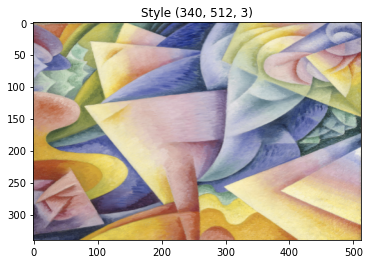

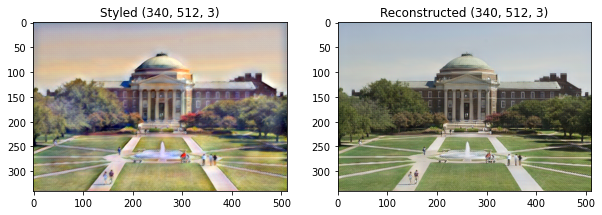

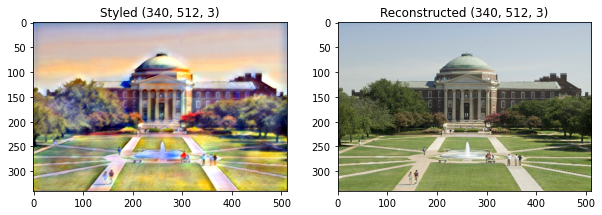

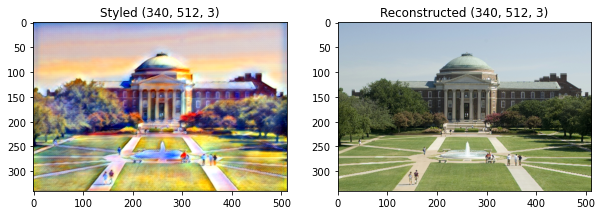

In [135]:
imshow(style_image,'Style')
for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(decoded_images[layer][0],'Styled')
    plt.subplot(1,2,2)
    imshow(decoded_images[layer][1],'Reconstructed')